In [1]:
from pathlib import Path

import tifffile
from typing import Union
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
import albumentations as Aug

from careamics_portfolio import PortfolioManager
from careamics.prediction import stitch_prediction
from careamics.lightning_module import (
    CAREamicsModule,
    CAREamicsTrainValDataModule,
    CAREamicsPredictDataModule,
    CAREamicsFiring,
    predict_tiled_simple,
)
from careamics.config.data import DataModel
from careamics.utils.metrics import psnr
from careamics.dataset.dataset_utils import read_tiff
from careamics.utils.transforms import ManipulateN2V

### Import Dataset Portfolio

In [2]:
# Explore portfolio
portfolio = PortfolioManager()
print(portfolio.denoising)

denoising datasets: ['N2V_BSD68', 'N2V_SEM', 'N2V_RGB', 'Flywing', 'Convallaria']


In [3]:
# Download and unzip the files
root_path = Path("data")
files = portfolio.denoising.N2V_BSD68.download(root_path)
print(f"List of downloaded files: {files}")

List of downloaded files: ['/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/__MACOSX/BSD68_reproducibility_data/._.DS_Store', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/__MACOSX/BSD68_reproducibility_data/test/._.DS_Store', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/.DS_Store', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/.DS_Store', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_25.tiff', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_21.tiff', '/home/igor.zubarev/projects/caremics/examples/2D/n2v/data/denoising-N2V_BSD68.unzip/BSD68_reproducibility_data/test/gt/bsd68_groundtruth_3.tiff', '/

In [4]:
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)
test_path.mkdir(parents=True, exist_ok=True)
gt_path.mkdir(parents=True, exist_ok=True)

### Visualize training data

Train image shape: (180, 180)


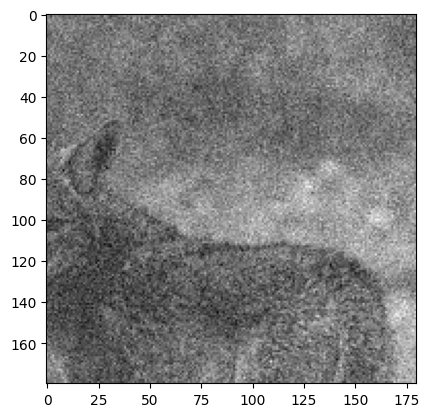

In [5]:
train_image = tifffile.imread(next(iter(train_path.rglob("*.tiff"))))[0]
print(f"Train image shape: {train_image.shape}")
plt.imshow(train_image, cmap="gray")

### Visualize validation data

Validation image shape: (180, 180)


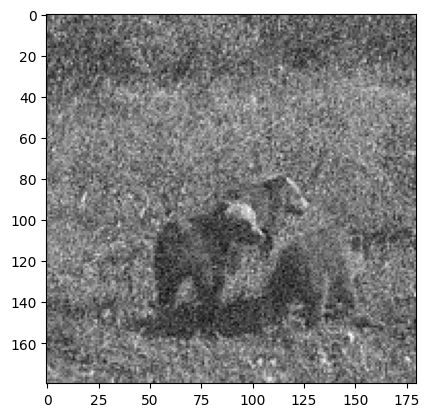

In [6]:
val_image = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))[0]
print(f"Validation image shape: {val_image.shape}")
plt.imshow(val_image, cmap="gray")

### Initialize the Model

Create a Pytorch Lightning module

Please take as look at the [documentation](https://careamics.github.io) to see the full list of parameters and configuration options

In [52]:
model = CAREamicsModule(
    algorithm="n2v",
    loss="n2v",
    architecture="UNet",
)


### Define the Transforms

In [53]:
transforms = Aug.Compose(
    [Aug.Flip(), Aug.RandomRotate90(), Aug.Normalize(), ManipulateN2V()],
)

### Initialize the datamodule

In [57]:
train_data_module = CAREamicsTrainValDataModule(
    train_path=train_path,
    val_path=val_path,
    data_type="tiff",
    patch_size=(64, 64),
    axes="SYX",
    batch_size=128,
    transforms=transforms,
    num_workers=4,
)

### Run training 

We need to specify the paths to training and validation data

In [58]:
trainer = Trainer(max_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [59]:
trainer.fit(model, datamodule=train_data_module)

Computed dataset mean: 110.72953033447266, std: 63.656009674072266
Computed dataset mean: 96.2784652709961, std: 60.512428283691406
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 361 K 
-------------------------------
361 K     Trainable params
0         Non-trainable params
361 K     Total params
1.446     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/light/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/light/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


### Define a prediction datamodule

In [9]:
transforms_predict = Aug.Compose(
    [Aug.Normalize()],
)

In [87]:
pred_data_module = CAREamicsPredictDataModule(
    pred_path=test_path,
    data_type="tiff",
    tile_size=(256, 256),
    axes="YX",
    batch_size=1,
    num_workers=0,
    transforms=transforms_predict,
)

### Run prediction

We need to specify the path to the data we want to denoise

In [134]:
tiled_loop = CAREamicsFiring(trainer)

In [135]:
trainer.predict_loop = tiled_loop

In [139]:
preds = trainer.predict(model, datamodule=pred_data_module)

Calculated mean and std for 68 images
Mean: 109.97985693987678, std: 58.40851918388815
Calculated mean and std for 68 images
Mean: 109.97985693987678, std: 58.40851918388815
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mambaforge/envs/light/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize results and compute metrics


In [78]:
predicted_array = []
tiles = []
stitching_data = []

for tile, data in preds:
    last_tile, *data = data
    tiles.append(tile)
    stitching_data.append(data)
    if last_tile:
        pred = denormalize(stitch_prediction(tiles, stitching_data), 109.979, 58.408)
        predicted_array.append(pred)
        tiles = []
        stitching_data = []
        tiles.clear()
        stitching_data.clear()
    
denormalized_image = denormalize

In [ ]:
preds = predict_tiled_simple(preds)

In [47]:
# Create a list of ground truth images

gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

Text(0.5, 1.0, 'Ground truth')

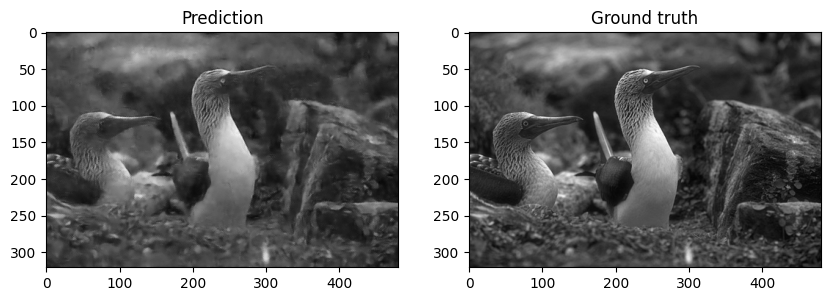

In [79]:
# Plot single image

image_idx = 0
_, subplot = plt.subplots(1, 2, figsize=(10, 10))

subplot[0].imshow(predicted_array[image_idx].squeeze(), cmap="gray")
subplot[0].set_title("Prediction")
subplot[1].imshow(gts[image_idx], cmap="gray")
subplot[1].set_title("Ground truth")

In [83]:
# Calculate PSNR for single image

psnr_single = psnr(gts[image_idx], predicted_array[image_idx].squeeze())
print(f"PSNR for image {image_idx}: {psnr_single}")

PSNR for image 0: 28.914092368538803


In [ ]:
psnr_total = 0

for pred, gt in zip(preds, gts):
    psnr_total += psnr(gt, pred)

print(f"PSNR total: {psnr_total / len(preds)}")

### Export to bioimage.io

In [ ]:
engine.save_as_bioimage(engine.cfg.experiment_name + "bioimage.zip")